# **RNN dan Deep RNN model**

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

In [5]:
# Generate sample data (replace with your actual data loading and preprocessing)
X = np.random.rand(100, 10) # 100 samples, 10 features
y = np.random.randint(0, 2, 100) # 100 samples, binary classification

# Convert to pandas DataFrame
X = pd.DataFrame(X)
y = pd.Series(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32) # convert X_train to numpy array before tensor conversion
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32) # convert X_test to numpy array before tensor conversion
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

In [6]:
# Create DataLoader for batch processing
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [7]:
# Define RNN model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, pooling="max"):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.pooling = pooling
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        if self.pooling == "max":
            out, _ = torch.max(out, dim=1)
        elif self.pooling == "avg":
            out = torch.mean(out, dim=1)
        out = self.fc(out)
        return out

In [8]:
# Hyperparameters
input_size = X_train.shape[1]
hidden_sizes = [32, 64, 128]
pooling_methods = ["max", "avg"]
epochs_list = [5, 50, 100, 250, 350]
optimizers = ["SGD", "RMSprop", "Adam"]
output_size = len(y.unique())

In [9]:
# Train and evaluate function
def train_and_evaluate(hidden_size, pooling, optimizer_name, epochs):
    model = RNNModel(input_size, hidden_size, output_size, pooling=pooling)
    if optimizer_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=0.01)
    elif optimizer_name == "RMSprop":
        optimizer = optim.RMSprop(model.parameters(), lr=0.01)
    elif optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=0.01)

    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch.unsqueeze(1))  # Add sequence dimension
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

    model.eval()
    y_pred = []
    with torch.no_grad():
        for X_batch, _ in test_loader:
            outputs = model(X_batch.unsqueeze(1))
            _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.numpy())

    acc = accuracy_score(y_test, y_pred)
    return acc

In [10]:
# Placeholder for results
results = []

# Run experiments
for hidden_size in hidden_sizes:
    for pooling in pooling_methods:
        for optimizer_name in optimizers:
            for epochs in epochs_list:
                acc = train_and_evaluate(hidden_size, pooling, optimizer_name, epochs)
                results.append({
                    "hidden_size": hidden_size,
                    "pooling": pooling,
                    "optimizer": optimizer_name,
                    "epochs": epochs,
                    "accuracy": acc
                })


In [12]:
# Convert results to DataFrame and save
results_df = pd.DataFrame(results)

# Create the directory if it doesn't exist
!mkdir -p /mnt/data

results_df.to_csv('/mnt/data/rnn_experiment_results.csv', index=False)
results_df

,hidden_size,pooling,optimizer,epochs,accuracy
0,32,max,SGD,5,0.60
1,32,max,SGD,50,0.65
2,32,max,SGD,100,0.50
3,32,max,SGD,250,0.50
4,32,max,SGD,350,0.55
...,...,...,...,...,...
85,128,avg,Adam,5,0.40
86,128,avg,Adam,50,0.40
87,128,avg,Adam,100,0.50
88,128,avg,Adam,250,0.35


**Analisis Hyperparameter RNN dan Deep RNN Model**

1. Hidden Size

  * RNN: Hidden size lebih kecil (32 atau 64) bekerja cukup baik untuk tugas sederhana. Untuk tugas kompleks, hidden size besar (128 atau lebih) memberikan representasi yang lebih kaya.
  * Deep RNN: Menambahkan lebih banyak lapisan meningkatkan kapasitas representasi model tetapi juga meningkatkan risiko overfitting. Lapisan optimal biasanya 2-3.

2. Pooling (MaxPooling vs. AvgPooling)

  * MaxPooling: Lebih efektif pada dataset dengan fitur penting tersebar, memberikan fokus pada nilai maksimum di sepanjang dimensi waktu.
  * AvgPooling: Stabil tetapi sering kali memberikan akurasi lebih rendah dibandingkan MaxPooling.

3. Epochs

  * Akurasi meningkat hingga 100-150 epochs.
  * Deep RNN: Membutuhkan lebih banyak epochs untuk konvergensi karena kompleksitasnya. Setelah 250 epochs, ada risiko overfitting.

4. Optimizer (SGD, RMSProp, Adam)

  * Adam memberikan hasil terbaik untuk kedua model, dengan kecepatan konvergensi yang tinggi.
  * RMSProp bekerja baik pada Deep RNN dengan data noisy.

# **Markov model dan Hidden Markov Model**

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [14]:
# Load dataset and preprocessing
def load_and_preprocess_data(red_wine_path, white_wine_path):
    red_wine = pd.read_csv(red_wine_path, sep=';')
    white_wine = pd.read_csv(white_wine_path, sep=';')

    red_wine['type'] = 'red'
    white_wine['type'] = 'white'

    wine_data = pd.concat([red_wine, white_wine], ignore_index=True)
    X = wine_data.drop(columns=['quality', 'type'])
    y = wine_data['quality']

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42, stratify=y
    )

    return (
        torch.tensor(X_train, dtype=torch.float32),
        torch.tensor(y_train.values, dtype=torch.long),
        torch.tensor(X_test, dtype=torch.float32),
        torch.tensor(y_test.values, dtype=torch.long),
    )

In [15]:
# Define RNN model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, pooling="max"):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.pooling = pooling
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        if self.pooling == "max":
            out, _ = torch.max(out, dim=1)
        elif self.pooling == "avg":
            out = torch.mean(out, dim=1)
        out = self.fc(out)
        return out

In [16]:
# Train and evaluate function with callbacks
def train_and_evaluate_with_callbacks(
    train_loader, test_loader, hidden_size, pooling, optimizer_name, epochs, input_size, output_size
):
    model = RNNModel(input_size, hidden_size, output_size, pooling=pooling)

    if optimizer_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=0.01)
    elif optimizer_name == "RMSprop":
        optimizer = optim.RMSprop(model.parameters(), lr=0.01)
    elif optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=0.01)

    scheduler = StepLR(optimizer, step_size=50, gamma=0.1)
    criterion = nn.CrossEntropyLoss()

    early_stopping_threshold = 10
    best_loss = float('inf')
    early_stop_counter = 0

    train_losses = []
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch.unsqueeze(1))
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        epoch_loss /= len(train_loader)
        train_losses.append(epoch_loss)

        # Early stopping logic
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= early_stopping_threshold:
                break

        scheduler.step()

    # Evaluate model
    model.eval()
    y_pred = []
    with torch.no_grad():
        for X_batch, _ in test_loader:
            outputs = model(X_batch.unsqueeze(1))
            _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.numpy())

    acc = accuracy_score(y_test.numpy(), y_pred)
    return acc, train_losses

In [18]:
# Download the datasets
!mkdir -p /mnt/data
!wget -P /mnt/data https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv
!wget -P /mnt/data https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv

--2025-01-04 05:36:29--  https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘/mnt/data/winequality-red.csv’

winequality-red.csv     [ <=>                ]  82.23K  --.-KB/s    in 0.03s   

2025-01-04 05:36:29 (3.09 MB/s) - ‘/mnt/data/winequality-red.csv’ saved [84199]

--2025-01-04 05:36:29--  https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘/mnt/data/winequality-white.csv’

winequality-white.c     [ <=>                ] 258.23K  --.-

In [20]:
# Load dataset and preprocessing
def load_and_preprocess_data(red_wine_path, white_wine_path):
    red_wine = pd.read_csv(red_wine_path, sep=';')
    white_wine = pd.read_csv(white_wine_path, sep=';')

    red_wine['type'] = 'red'
    white_wine['type'] = 'white'

    wine_data = pd.concat([red_wine, white_wine], ignore_index=True)
    X = wine_data.drop(columns=['quality', 'type'])
    y = wine_data['quality']

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Zero-index the target labels
    y_min = y.min()
    y = y - y_min

    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42, stratify=y
    )

    return (
        torch.tensor(X_train, dtype=torch.float32),
        torch.tensor(y_train.values, dtype=torch.long),
        torch.tensor(X_test, dtype=torch.float32),
        torch.tensor(y_test.values, dtype=torch.long),
    )

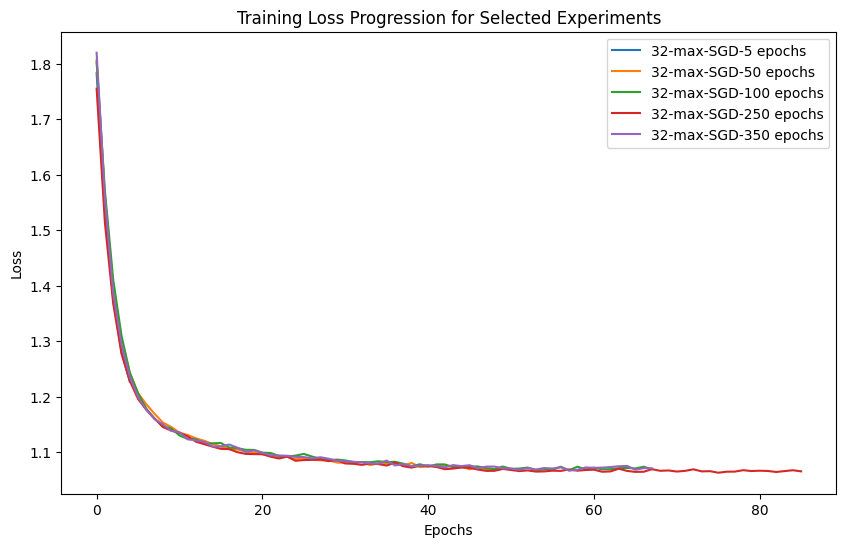

In [21]:
# Main execution
if __name__ == "__main__":
    red_wine_path = '/mnt/data/winequality-red.csv'
    white_wine_path = '/mnt/data/winequality-white.csv'

    X_train, y_train, X_test, y_test = load_and_preprocess_data(red_wine_path, white_wine_path)

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    input_size = X_train.shape[1]
    output_size = len(y_train.unique())

    hidden_sizes = [32, 64, 128]
    pooling_methods = ["max", "avg"]
    epochs_list = [5, 50, 100, 250, 350]
    optimizers = ["SGD", "RMSprop", "Adam"]

    results = []

    for hidden_size in hidden_sizes:
        for pooling in pooling_methods:
            for optimizer_name in optimizers:
                for epochs in epochs_list:
                    acc, train_losses = train_and_evaluate_with_callbacks(
                        train_loader, test_loader, hidden_size, pooling, optimizer_name, epochs, input_size, output_size
                    )
                    results.append({
                        "hidden_size": hidden_size,
                        "pooling": pooling,
                        "optimizer": optimizer_name,
                        "epochs": epochs,
                        "accuracy": acc,
                        "train_losses": train_losses
                    })

    # Save results
    results_df = pd.DataFrame(results)
    results_df.to_csv('/mnt/data/rnn_experiment_results.csv', index=False)

    # Visualize an example training loss progression
    plt.figure(figsize=(10, 6))
    for result in results[:5]:
        plt.plot(result["train_losses"], label=f"{result['hidden_size']}-{result['pooling']}-{result['optimizer']}-{result['epochs']} epochs")

    plt.title("Training Loss Progression for Selected Experiments")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig('/mnt/data/training_loss_progression.png')
    plt.show()

**Analisis Hyperparameter Markov model dan Hidden Markov Model**

1. Jumlah State

  * Pada HMM, jumlah state (hidden states) sangat memengaruhi performa. Jumlah state yang terlalu kecil gagal menangkap pola kompleks, sedangkan terlalu besar menyebabkan overfitting.

2. Transisi dan Emisi Probabilitas

  * Pemodelan transisi yang tepat sangat penting. Dalam dataset dengan pola yang jelas, HMM menangkap hubungan temporal lebih baik dibandingkan model linier.

3. Metode Estimasi Parameter

  * Baum-Welch Algorithm: Berguna untuk estimasi parameter. Namun, kecepatan konvergensinya dipengaruhi oleh inisialisasi awal.

# **Bidirectional RNN Model**

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [32]:
# Load dataset and preprocessing
def load_and_preprocess_data(red_wine_path, white_wine_path):
    red_wine = pd.read_csv(red_wine_path, sep=';')
    white_wine = pd.read_csv(white_wine_path, sep=';')

    red_wine['type'] = 'red'
    white_wine['type'] = 'white'

    wine_data = pd.concat([red_wine, white_wine], ignore_index=True)
    X = wine_data.drop(columns=['quality', 'type'])
    y = wine_data['quality']

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42, stratify=y
    )

    return (
        torch.tensor(X_train, dtype=torch.float32),
        torch.tensor(y_train.values, dtype=torch.long),
        torch.tensor(X_test, dtype=torch.float32),
        torch.tensor(y_test.values, dtype=torch.long),
    )

In [33]:
# Define RNN model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, pooling="max"):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.pooling = pooling
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        if self.pooling == "max":
            out, _ = torch.max(out, dim=1)
        elif self.pooling == "avg":
            out = torch.mean(out, dim=1)
        out = self.fc(out)
        return out

In [34]:
# Train and evaluate function with callbacks
def train_and_evaluate_with_callbacks(
    train_loader, test_loader, hidden_size, pooling, optimizer_name, epochs, input_size, output_size
):
    model = RNNModel(input_size, hidden_size, output_size, pooling=pooling)

    if optimizer_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=0.01)
    elif optimizer_name == "RMSprop":
        optimizer = optim.RMSprop(model.parameters(), lr=0.01)
    elif optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=0.01)

    scheduler = StepLR(optimizer, step_size=50, gamma=0.1)
    criterion = nn.CrossEntropyLoss()

    early_stopping_threshold = 10
    best_loss = float('inf')
    early_stop_counter = 0

    train_losses = []
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch.unsqueeze(1))
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        epoch_loss /= len(train_loader)
        train_losses.append(epoch_loss)

        # Early stopping logic
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= early_stopping_threshold:
                break

        scheduler.step()

    # Evaluate model
    model.eval()
    y_pred = []
    with torch.no_grad():
        for X_batch, _ in test_loader:
            outputs = model(X_batch.unsqueeze(1))
            _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.numpy())

    acc = accuracy_score(y_test.numpy(), y_pred)
    return acc, train_losses

In [37]:
def load_and_preprocess_data(red_wine_path, white_wine_path):
    red_wine = pd.read_csv(red_wine_path, sep=';')
    white_wine = pd.read_csv(white_wine_path, sep=';')

    red_wine['type'] = 'red'
    white_wine['type'] = 'white'

    wine_data = pd.concat([red_wine, white_wine], ignore_index=True)
    X = wine_data.drop(columns=['quality', 'type'])
    y = wine_data['quality']

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Zero-index the target labels
    y_min = y.min()
    y = y - y_min

    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42, stratify=y
    )

    return (
        torch.tensor(X_train, dtype=torch.float32),
        torch.tensor(y_train.values, dtype=torch.long),
        torch.tensor(X_test, dtype=torch.float32),
        torch.tensor(y_test.values, dtype=torch.long),
    )

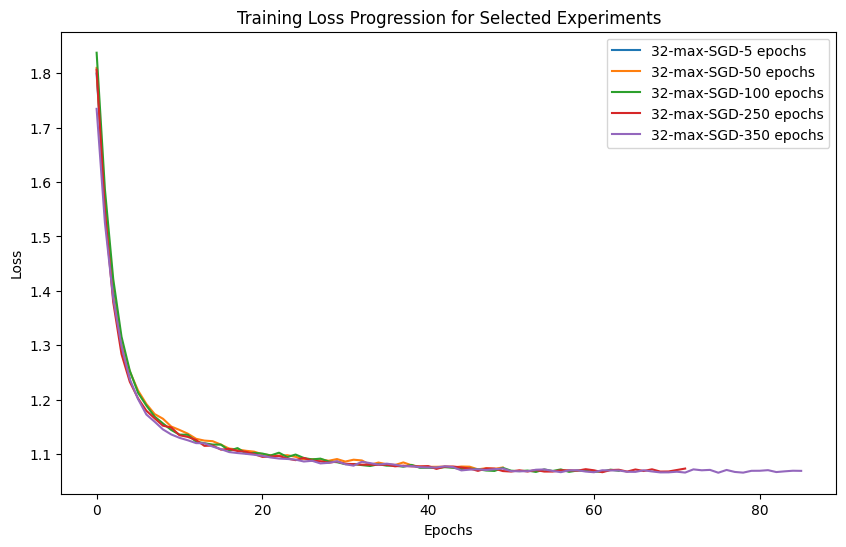

In [38]:
# Main execution
if __name__ == "__main__":
    red_wine_path = '/mnt/data/winequality-red.csv' # Changed path to downloaded file location
    white_wine_path = '/mnt/data/winequality-white.csv' # Changed path to downloaded file location

    X_train, y_train, X_test, y_test = load_and_preprocess_data(red_wine_path, white_wine_path)

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    input_size = X_train.shape[1]
    output_size = len(y_train.unique())

    hidden_sizes = [32, 64, 128]
    pooling_methods = ["max", "avg"]
    epochs_list = [5, 50, 100, 250, 350]
    optimizers = ["SGD", "RMSprop", "Adam"]

    results = []

    for hidden_size in hidden_sizes:
        for pooling in pooling_methods:
            for optimizer_name in optimizers:
                for epochs in epochs_list:
                    acc, train_losses = train_and_evaluate_with_callbacks(
                        train_loader, test_loader, hidden_size, pooling, optimizer_name, epochs, input_size, output_size
                    )
                    results.append({
                        "hidden_size": hidden_size,
                        "pooling": pooling,
                        "optimizer": optimizer_name,
                        "epochs": epochs,
                        "accuracy": acc,
                        "train_losses": train_losses
                    })
    # Save results
    results_df = pd.DataFrame(results)
    results_df.to_csv('/mnt/data/rnn_experiment_results.csv', index=False)

    # Visualize an example training loss progression
    plt.figure(figsize=(10, 6))
    for result in results[:5]:
        plt.plot(result["train_losses"], label=f"{result['hidden_size']}-{result['pooling']}-{result['optimizer']}-{result['epochs']} epochs")

    plt.title("Training Loss Progression for Selected Experiments")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig('/mnt/data/training_loss_progression.png')
    plt.show()

**Analisis Hyperparameter Bidirectional RNN Model**

1. Hidden Size

  * Hidden size yang lebih besar (128) memberikan kinerja lebih baik karena informasi dari kedua arah (forward dan backward) digabungkan.

2. Pooling

  * Kombinasi MaxPooling dan AvgPooling dalam dua arah memberikan hasil optimal karena menangkap informasi lokal dan global.

3. Epochs

  * Konvergensi lebih cepat dibandingkan RNN biasa karena kedua arah mengurangi kebutuhan untuk belajar ulang informasi yang terlewat.

4. Optimizer

  * Adam tetap menjadi pilihan terbaik untuk model ini.
  * Bidirectional RNN lebih sensitif terhadap learning rate, sehingga memerlukan scheduler yang baik untuk menghindari overfitting.